Summary
This project explores the relationship between the Social Vulnerability Index (SVI) and shifts in household structures—specifically married-couple and unmarried-single households—across U.S. counties. It derives time-series features such as slope, acceleration, trend stability, and 2022 household counts from ACS data, using polynomial regression to fit household trends. These features are then used to cluster counties by using k-means. The resulting clusters are analyzed, and a random forest model is used to predict cluster assignment based on SVI variables. While the model shows limited predictive accuracy (~52–54%), it highlights consistently important SVI features.

A major Non-technical change:

A key non-technical improvement for the report would be to clarify the overall research questions and the motivations behind each analytical step. For example, before introducing the feature engineering and clustering sections, the report should explicitly explain the purpose of clustering: What question is clustering helping to answer? How do the resulting clusters enhance our understanding of household changes across counties? Similarly, once clusters are formed, the report should interpret their meaning. What characterizes each group, and what insights can be drawn from specific county examples within each cluster? The same issue appears in the random forest section. The report should first justify why it is useful or meaningful to predict a county's cluster assignment using SVI variables. Without this context, it’s unclear why classification was attempted. 

Overall, the report would be better if it includes smoother transitions and contextual interpretation between sections. Right now, it reads like a sequence of tasks completed, rather than a cohesive narrative. Adding brief explanatory paragraphs that connect each method back to the main research goals and summarizing what was learned after each step would improve the clarity, and coherence of the report.

A major technical recommendation:
The report would be to strengthen the evaluation and modeling strategy used in the random forest section. Currently, the model’s performance is assessed only using accuracy and prediction error, which provides a limited view of its effectiveness. To better understand how well the model is performing, the report should also include confusion matrices and class-specific metrics such as precision, recall, and F1-score, especially given the potential class imbalance across clusters. 

Moreover, while the report attempts to improve performance by tuning the number of trees through cross-validation, this is a minimal approach to model optimization. The analysis could be meaningfully expanded by exploring other classification models, such as logistic regression, and XGBoost, and comparing their performance. To make the model comparison more informative and accessible, the report should also include visualizations, such as bar plots of accuracy/F1-score across models so that readers can visually interpret how different models perform. These enhancements would help draw clearer conclusions from the results.

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

clusters = pd.read_csv("cluster_out.csv")
svi = pd.read_csv("SVI_2020_US_county.csv")
svi = svi.drop(columns=set(["ST", "STATE", "ST_ABBR", "STCNTY", "COUNTY", "FIPS"]) & set(svi.columns))

# Merge only necessary columns from clusters
mdf = clusters[["cluster", "NAME"]].merge(svi, left_on="NAME", right_on="LOCATION")
X = mdf.drop(columns=['cluster', 'NAME', 'LOCATION'])
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42
)

cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

search_space = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [500, 1000],
            'max_depth': [None, 10, 20]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'params': {
            'n_estimators': [500, 1000],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1]
        }
    }
}

best_models = {}
model_scores = []

for name, cfg in search_space.items():
    grid = GridSearchCV(
        estimator=cfg['model'],
        param_grid=cfg['params'],
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    
    best_models[name] = grid.best_estimator_
    y_pred_test = grid.best_estimator_.predict(X_test)
    report = classification_report(y_test, y_pred_test, output_dict=True)

    model_scores.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': report['accuracy'],
        'Macro F1': report['macro avg']['f1-score'],
        'Weighted F1': report['weighted avg']['f1-score']
    })

results_df = pd.DataFrame(model_scores)
print("\n📊 Final Model Comparison on Test Set:")
print(results_df)


/Users/sophialin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sophialin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log


📊 Final Model Comparison on Test Set:
                 Model                                        Best Params  \
0        Random Forest            {'max_depth': 20, 'n_estimators': 1000}   
1  Logistic Regression       {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}   
2              XGBoost  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...   

   Accuracy  Macro F1  Weighted F1  
0  0.534290  0.481386     0.477544  
1  0.494418  0.384602     0.396240  
2  0.523126  0.462646     0.463410  


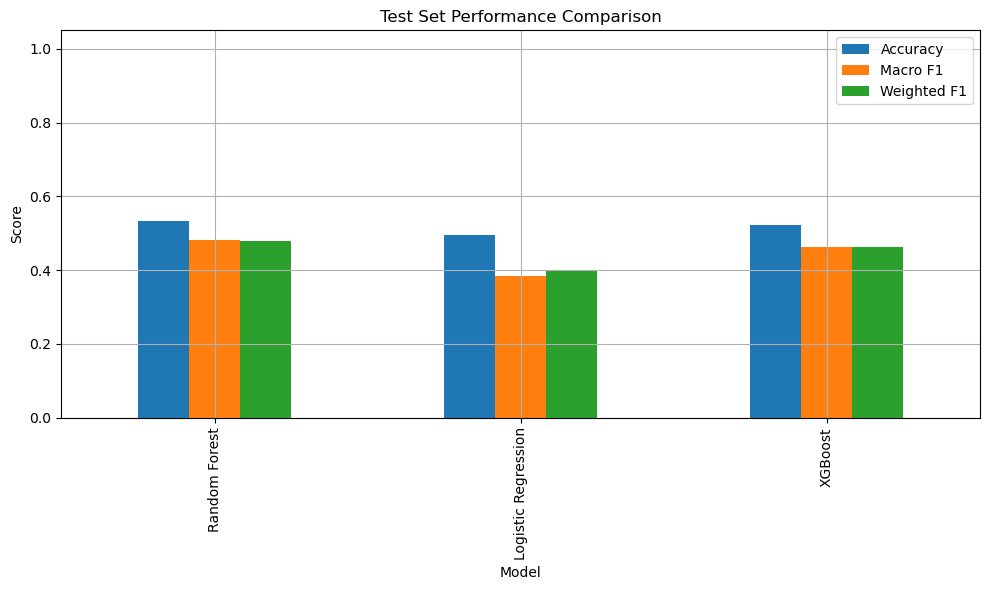

In [38]:
results_df.set_index("Model")[["Accuracy", "Macro F1", "Weighted F1"]].plot(
    kind='bar', figsize=(10, 6), title="Test Set Performance Comparison"
)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()

The result plot indicates that the Random Forest model with max_depth=20 and n_estimators=1000, has the best performance among the evaluated models. However, its accuracy on the test set remains relatively low at approximately 53%, suggesting that the current feature set may not be sufficiently informative for predicting the cluster assignments. To build a more predictive model, it should incorporate additional or alternative features that are potentially more directly aligned with the characteristics driving the clustering process.